# Network analysis in Oslo, Norway

Network analysis introduction using the OSMnx package. Documentation: https://osmnx.readthedocs.io/en/stable/user-reference.html    
When working with OSMnx, remember that can always search/check https://www.openstreetmap.org/ to see what data exists and corresponding attributes.

In [1]:
# import OSMnx library
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
from shapely.ops import unary_union

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

## 1. Get administrative place boundaries and shapefiles
With OSMnx, you can download place shapes from OpenStreetMap (as geopandas GeoDataFrames) in one line of Python code – and project them to UTM (zone calculated automatically) and visualize in just one more line of code.   


You can pass multiple places into a single query to save a single shapefile or geopackage from their geometries. You can do this with cities, states, countries or any other geographic entities:

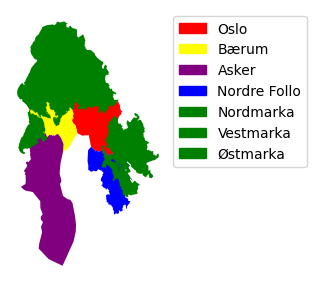

In [2]:
# Fetch individual geodataframes for each place
oslo_gdf = ox.geocode_to_gdf("Oslo, Norway")
baerum_gdf = ox.geocode_to_gdf("Bærum, Norway")
asker_gdf = ox.geocode_to_gdf("Asker, Norway")
nordre_follo_gdf = ox.geocode_to_gdf("Nordre Follo, Norway")
nordmarka_gdf = ox.geocode_to_gdf("Nordmarka, Norway", which_result=1)
vestmarka_gdf = ox.geocode_to_gdf("Vestmarka, Norway")
ostmarka_gdf = ox.geocode_to_gdf("Østmarka, Norway")

# Concatenate the geodataframes
places = gpd.GeoDataFrame(pd.concat([oslo_gdf, baerum_gdf, asker_gdf, nordre_follo_gdf, nordmarka_gdf, vestmarka_gdf, ostmarka_gdf], ignore_index=True), crs=oslo_gdf.crs)
places = ox.project_gdf(places)

# Set the figure size
fig, ax = plt.subplots(figsize=(3, 4))  # Adjust the size values as needed
colors = ['red', 'yellow', 'purple', 'blue', 'green', 'green', 'green']
places.plot(facecolor=colors, ax=ax)
_ = ax.axis('off')

legend_labels = ['Oslo', 'Bærum', 'Asker', 'Nordre Follo', 'Nordmarka', 'Vestmarka', 'Østmarka']
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
ax.legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 10})
plt.tight_layout()
plt.show()

Note that when we query for a place using ox.geocode_to_gdf(), OSMnx by default returns the first matching OSM feature.  
For "Nordmarka, Norway" we get the results: 
- Relation: Nordmarka (1904403), a smaller woodland polygon instead of  
- Relation: Nordmarka (16452430), which is the larger protected area we wanted

If the target feature is not the top result we can adjust ```which_result``` to get the right feature (this can change over time).

In [3]:
# Fetch Geodataframes and inspect data types
oslo_gdf = ox.geocode_to_gdf("Oslo, Norway")
nordmarka_gdf = ox.geocode_to_gdf("Nordmarka, Norway", which_result=1) # adjust "which_result" if necessary

print(type(oslo_gdf))
print(type(oslo_gdf.iloc[0].geometry))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'shapely.geometry.polygon.Polygon'>


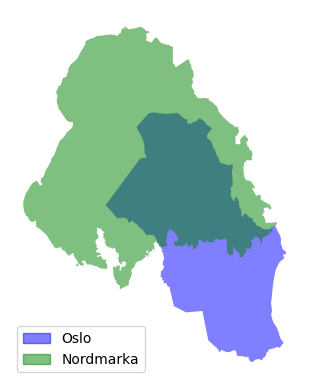

In [4]:
# Project to the same CRS
oslo_gdf_projected = ox.project_gdf(oslo_gdf)
nordmarka_gdf_projected = nordmarka_gdf.to_crs(oslo_gdf_projected.crs)

# Plotting
fig, ax = plt.subplots()
oslo_gdf_projected.plot(ax=ax, color='blue', alpha=0.5)
nordmarka_gdf_projected.plot(ax=ax, color='green', alpha=0.5)

# Create legend patches
oslo_patch = mpatches.Patch(color='blue', alpha=0.5, label='Oslo')
nordmarka_patch = mpatches.Patch(color='green', alpha=0.5, label='Nordmarka')
ax.legend(handles=[oslo_patch, nordmarka_patch], loc='lower left')

ax.axis('off')
plt.show()

> #### Small note, if cannot easily get geometry with OSMnx
> Another way to get the right feature is to query OSM manually (e.g., using the **Overpass API**) and pass the resulting polygon into OSMnx.    
> We can do this using the **overpy** package like this for the Nordmarka polygon:

> ```python
> # Overpass API query
> overpass_api = overpy.Overpass()
> nordmarka_query = overpass_api.query("relation(16452430);(._;>;);out;")
> 
> # Parse the result to get the Polygon
> nodes = [(float(node.lon), float(node.lat)) for node in nordmarka_query.nodes]
> nordmarka_poly = Polygon(nodes)   
> ```

## 2. Visualize street network
We can specify several different network types:   
- **‘drive’** – get drivable public streets (but not service roads)
- **‘drive_service’** – get drivable public streets, including service roads
- **‘walk’** – get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
- **‘bike’** – get all streets and paths that cyclists can use
- **‘all’** – download all (non-private) OSM streets and paths
- **‘all_private’** – download all OSM streets and paths, including private-access ones

Since we are only interested in the urban landscape of Oslo for the network analysis, we subtract Nordmarka from Oslo municipality like so:

$$ \text{Oslo Urban Landscape} = \text{Oslo municipality} - \text{Nordmarka} $$


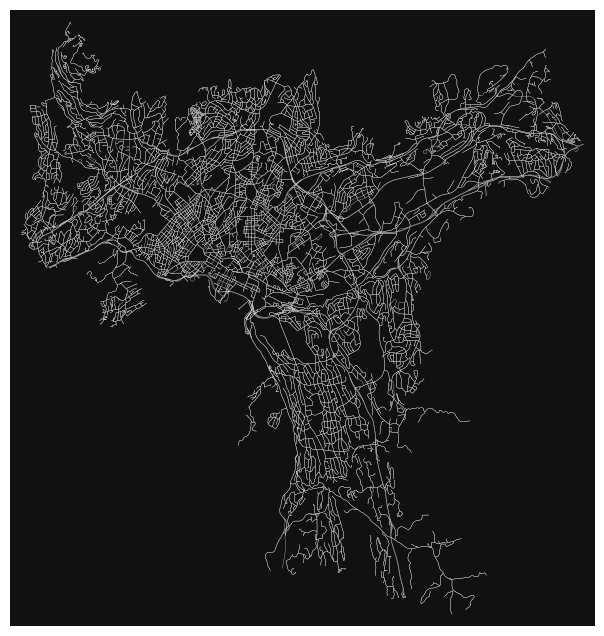

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
# Compute the difference between Oslo and Nordmarka geometries
oslo_geometry = oslo_gdf.iloc[0].geometry
nordmarka_geometry = nordmarka_gdf.iloc[0].geometry
difference_geometry = oslo_geometry.difference(nordmarka_geometry)

# Fetch the road network for the resultant area
# oslo_network = ox.graph_from_polygon(difference_geometry, network_type="drive_service")
oslo_graph = ox.graph_from_polygon(difference_geometry, network_type="drive")
ox.plot_graph(oslo_graph, node_size=0, edge_color="w", edge_linewidth=0.2)

In [6]:
print(type(oslo_graph))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


### Zooming in on road network of Grünerløkka in Oslo

#### Comparing main roads with service roads
Should service roads be included in further analysis?

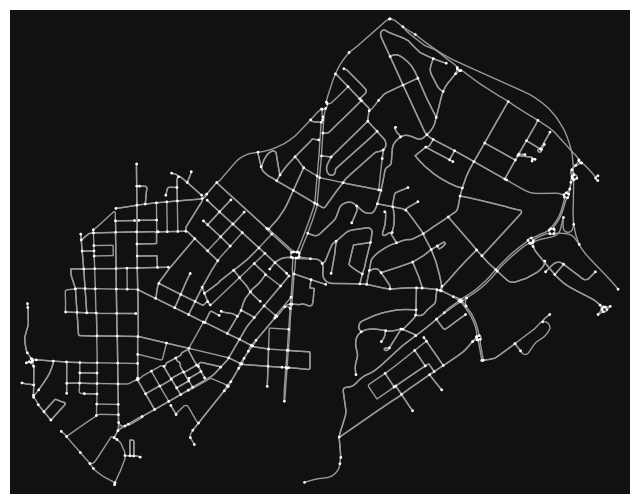

CPU times: total: 1.36 s
Wall time: 1.77 s


(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
%%time
# gruner = ox.graph_from_place('Grünerløkka, Oslo, Norway')
gruner_graph = ox.graph_from_place('Grünerløkka, Oslo, Norway', network_type="drive")
# gruner_graph = ox.graph_from_place('Grünerløkka, Oslo, Norway', network_type="drive_service") # road network including service roads
ox.plot_graph(gruner_graph, node_size=4)

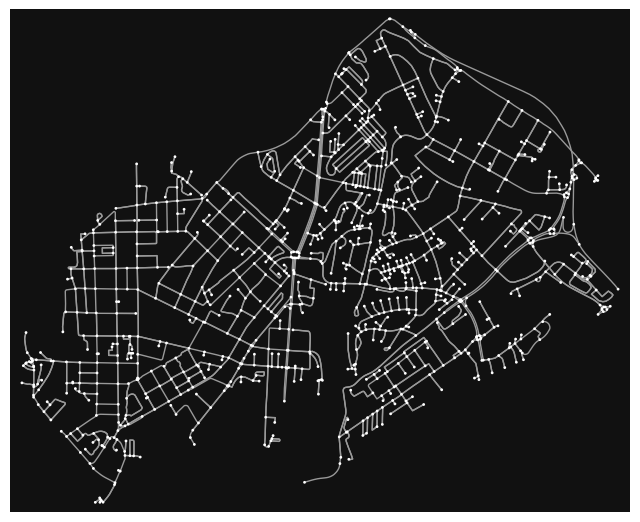

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
# gruner = ox.graph_from_place('Grünerløkka, Oslo, Norway', network_type="drive")
gruner_graph = ox.graph_from_place('Grünerløkka, Oslo, Norway', network_type="drive_service")
ox.plot_graph(gruner_graph, node_size=4)

Based on the plots above, it looks like service roads could be important for further network analysis, including them to begin with.

## 3. Explore Tabular data format and statistics
We can get GeoPandas GeoDataFrames from areas with:

In [9]:
gruner_gdf = ox.geocode_to_gdf("Grünerløkka, Oslo, Norway")
print(f"type of gruner_gdf:{type(gruner_gdf)}")
gruner_gdf.head()

type of gruner_gdf:<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((10.74799 59.91964, 10.74992 59.91939...",59.937559,59.913477,10.80766,10.747989,144212303,relation,1279942,59.925471,10.777421,boundary,administrative,18,0.30001,suburb,Grünerløkka,"Grünerløkka, Oslo, Norway"


OSMnx models all networks as NetworkX MultiDiGraph objects. You can convert from MultiDiGraph to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

In [10]:
# We already have 'gruner' on the standard network format: MultiDiGraph
print(f"type of gruner:{type(gruner_graph)}")

# we can convert the graph to node and edge GeoPandas GeoDataFrames
gruner_gdf_nodes, gruner_gdf_edges = ox.graph_to_gdfs(gruner_graph)
print(f"type of gruner_gdf_nodes:{type(gruner_gdf_nodes)}")

type of gruner:<class 'networkx.classes.multidigraph.MultiDiGraph'>
type of gruner_gdf_nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


In [11]:
gruner_gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
79448,59.921558,10.750823,3,NaN,NaN,POINT (10.75082 59.92156)
79465,59.928495,10.761100,4,traffic_signals,NaN,POINT (10.76110 59.92850)
79475,59.928343,10.759132,3,traffic_signals,NaN,POINT (10.75913 59.92834)
79476,59.928694,10.764892,4,traffic_signals,NaN,POINT (10.76489 59.92869)
79490,59.929560,10.768588,5,traffic_signals,NaN,POINT (10.76859 59.92956)


In [12]:
gruner_gdf_edges.head()

osmid lanes           name    highway  \
u     v          key                                                           
79448 3165357950 0                 129061337     2  Maridalsveien  secondary   
79465 106183     0                   4211442     2    Toftes gate  secondary   
      12630987   0                 349267814     2    Toftes gate  secondary   
      79475      0    [882463938, 337073150]     3     Sannergata   tertiary   
      12630988   0                 882463954     3     Sannergata   tertiary   

                      oneway reversed   length  \
u     v          key                             
79448 3165357950 0     False    False  107.935   
79465 106183     0     False     True  139.757   
      12630987   0     False    False   99.113   
      79475      0     False     True  111.025   
      12630988   0     False    False   44.617   

                                                               geometry  \
u     v          key                                                      
79448 3165357950 0    LINESTRING (10.75082 59.92156, 10.75078 59.921...   
79465 106183     0    LINESTRING (10.76110 59.92850, 10.76110 59.928...   
      12630987   0    LINESTRING (10.76110 59.92850, 10.76110 59.928...   
      79475      0    LINESTRING (10.76110 59.92850, 10.76107 59.928...   
      12630988   0    LINESTRING (10.76110 59.92850, 10.76113 59.928...   

                     maxspeed  ref junction bridge service width access tunnel  
u     v          key                                                            
79448 3165357950 0        NaN  NaN      NaN    NaN     NaN   NaN    NaN    NaN  
79465 106183     0        NaN  NaN      NaN    NaN     NaN   NaN    NaN    NaN  
      12630987   0         40  NaN      NaN    NaN     NaN   NaN    NaN    NaN  
      79475      0         40  NaN      NaN    NaN     NaN   NaN    NaN    NaN  
      12630988   0         40  NaN      NaN    NaN     NaN   NaN    NaN    NaN

You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge ShapeFiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [13]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
gruner_graph2 = ox.graph_from_gdfs(gruner_gdf_nodes, gruner_gdf_edges, graph_attrs=gruner_graph.graph)
print(f"type of gruner_graph2:{type(gruner_graph2)}")

type of gruner_graph2:<class 'networkx.classes.multidigraph.MultiDiGraph'>


### Basic street network stats
stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [14]:
# what sized area does our network cover in square meters?
gruner_graph_proj = ox.project_graph(gruner_graph)
gruner_gdf_nodes_proj = ox.graph_to_gdfs(gruner_graph_proj, edges=False)
graph_area_m = gruner_gdf_nodes_proj.unary_union.convex_hull.area
print(f"Area of Study area=Grünerløkka is: {round(graph_area_m, 0)} square meters")
print("Yes, confirmed value makes sense on google maps.")

Area of Study area=Grünerløkka is: 5059441.0 square meters
Yes, confirmed value makes sense on google maps.


In [15]:
ox.basic_stats(gruner_graph_proj, area=graph_area_m, clean_int_tol=15)

{'n': 1111,
 'm': 2382,
 'k_avg': 4.288028802880288,
 'edge_length_total': 153310.48799999984,
 'edge_length_avg': 64.36208564231731,
 'streets_per_node_avg': 2.514851485148515,
 'streets_per_node_counts': {0: 0, 1: 317, 2: 14, 3: 672, 4: 107, 5: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.28532853285328535,
  2: 0.012601260126012601,
  3: 0.6048604860486049,
  4: 0.0963096309630963,
  5: 0.0009000900090009},
 'intersection_count': 794,
 'street_length_total': 88294.265,
 'street_segment_count': 1360,
 'street_length_avg': 64.92225367647059,
 'circuity_avg': 1.0792728274437349,
 'self_loop_proportion': 0.004411764705882353,
 'clean_intersection_count': 455,
 'node_density_km': 219.58948976955793,
 'intersection_density_km': 156.93434282360846,
 'edge_density_km': 30301.864839101618,
 'street_density_km': 17451.38847968329,
 'clean_intersection_density_km': 89.93088914954892}

### Save Graph networks to disc
Save graph to disk as geopackage (for GIS) or graphml file (for gephi etc).   
To save/load full-featured OSMnx graphs to/from disk for later use, use the save_graphml and load_graphml.

In [16]:
# Saving Grünerløkka road network incl. service roads
ox.save_graph_geopackage(gruner_graph, filepath="./data/grünerlokka_road_network.gpkg")
ox.save_graphml(gruner_graph, filepath="./data/grünerlokka_road_network.graphml")

# Saving Oslo road network incl. service roads
ox.save_graph_geopackage(oslo_graph, filepath="./data/oslo_road_network.gpkg")
ox.save_graphml(oslo_graph, filepath="./data/oslo_road_network.graphml")

## 4. Visualize street centrality and travel routes
Here we plot the street network and color its edges (streets) by their relative closeness centrality.

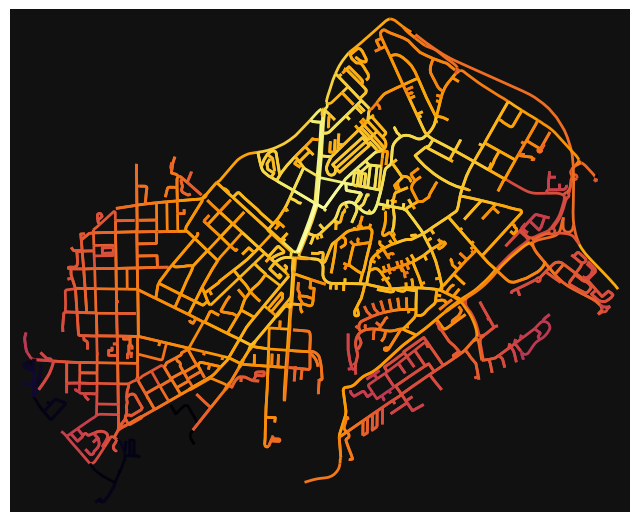

In [17]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(gruner_graph))
nx.set_edge_attributes(gruner_graph, edge_centrality, "edge_centrality")

# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(gruner_graph, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(gruner_graph, edge_color=ec, edge_linewidth=2, node_size=0)

In [18]:
%%time
# Same for larger Oslo area
# convert graph to line graph so edges become nodes and vice versa
edge_centrality_oslo = nx.closeness_centrality(nx.line_graph(oslo_graph))
nx.set_edge_attributes(oslo_graph, edge_centrality_oslo, "edge_centrality")

KeyboardInterrupt: 

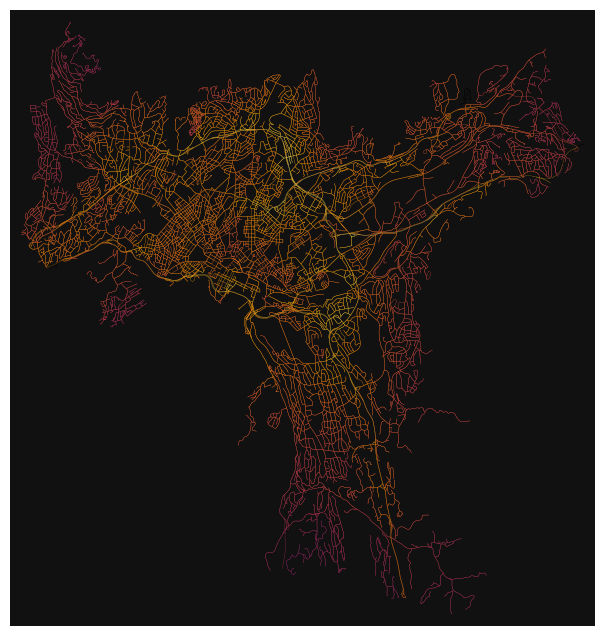

In [ ]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(oslo_graph, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(oslo_graph, edge_color=ec, edge_linewidth=0.2, node_size=0)

### Routing
#### Inspecting GeoDataFrames before adding edge(road) speeds

In [19]:
# converting graph to node and edge GeoPandas GeoDataFrames
gruner_gdf_nodes, gruner_gdf_edges = ox.graph_to_gdfs(gruner_graph)
print(f"type of gruner_gdf_nodes:{type(gruner_gdf_nodes)}")
gruner_gdf_edges.keys()

type of gruner_gdf_nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


Index(['osmid', 'lanes', 'name', 'highway', 'oneway', 'reversed', 'length',
       'geometry', 'edge_centrality', 'maxspeed', 'ref', 'junction', 'bridge',
       'service', 'width', 'access', 'tunnel'],
      dtype='object')

In [20]:
# Select a subset of columns - before imputing edge speeds
subset_columns = ['lanes', 'name', 'highway', 'oneway', 'reversed', 'length', 'edge_centrality', 'maxspeed', 'ref', 'junction', 'bridge', 'width', 'tunnel']
subset_gdf = gruner_gdf_edges[subset_columns]
subset_gdf.head(4)

lanes           name    highway  oneway reversed  \
u     v          key                                                    
79448 3165357950 0       2  Maridalsveien  secondary   False    False   
79465 106183     0       2    Toftes gate  secondary   False     True   
      12630987   0       2    Toftes gate  secondary   False    False   
      79475      0       3     Sannergata   tertiary   False     True   

                       length  edge_centrality maxspeed  ref junction bridge  \
u     v          key                                                           
79448 3165357950 0    107.935         0.025421      NaN  NaN      NaN    NaN   
79465 106183     0    139.757         0.034285      NaN  NaN      NaN    NaN   
      12630987   0     99.113         0.034285       40  NaN      NaN    NaN   
      79475      0    111.025         0.034285       40  NaN      NaN    NaN   

                     width tunnel  
u     v          key               
79448 3165357950 0     NaN    NaN  
79465 106183     0     NaN    NaN  
      12630987   0     NaN    NaN  
      79475      0     NaN    NaN

#### Imputing edge speeds and inspecting new columns in resulting GeoDataFrame
The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [21]:
# impute speed on all edges missing data
gruner_graph = ox.speed.add_edge_speeds(gruner_graph)

# calculate travel time (seconds) for all edges
gruner_graph = ox.speed.add_edge_travel_times(gruner_graph)

# converting graph to node and edge GeoPandas GeoDataFrames
gruner_gdf_nodes, gruner_gdf_edges = ox.graph_to_gdfs(gruner_graph)
print(f"type of gruner_gdf_nodes:{type(gruner_gdf_nodes)}")
gruner_gdf_edges.keys()

type of gruner_gdf_nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


Index(['osmid', 'lanes', 'name', 'highway', 'oneway', 'reversed', 'length',
       'geometry', 'edge_centrality', 'speed_kph', 'travel_time', 'maxspeed',
       'ref', 'junction', 'bridge', 'service', 'width', 'access', 'tunnel'],
      dtype='object')

In [22]:
# Select a subset of columns
subset_columns = ['lanes', 'name', 'highway', 'oneway', 'reversed', 'length', 'edge_centrality', 'speed_kph', 'travel_time', 'maxspeed', 
                  'ref', 'junction', 'bridge', 'service', 'width', 'access', 'tunnel']
subset_gdf = gruner_gdf_edges[subset_columns]
subset_gdf.head(12)

lanes                                         name  \
u     v          key                                                      
79448 3165357950 0       2                                Maridalsveien   
79465 106183     0       2                                  Toftes gate   
      12630987   0       2                                  Toftes gate   
      79475      0       3                                   Sannergata   
      12630988   0       3                                   Sannergata   
79475 79465      0       3                                   Sannergata   
79476 12534271   0     NaN                               Christies gate   
      79491      0       3                                   Sannergata   
      660503     0       3                                   Sannergata   
79490 3444709339 0       4                                Fagerheimgata   
      356214340  0       4                    Christian Michelsens gate   
      79508      0       2  [Mailundveien, Fagerheimgata; Mailundveien]   

                          highway  oneway reversed   length  edge_centrality  \
u     v          key                                                           
79448 3165357950 0      secondary   False    False  107.935         0.025421   
79465 106183     0      secondary   False     True  139.757         0.034285   
      12630987   0      secondary   False    False   99.113         0.034285   
      79475      0       tertiary   False     True  111.025         0.034285   
      12630988   0       tertiary   False    False   44.617         0.034285   
79475 79465      0       tertiary   False    False  111.025         0.033135   
79476 12534271   0    residential   False     True   70.619         0.036980   
      79491      0       tertiary   False    False  130.697         0.036980   
      660503     0       tertiary   False     True   55.254         0.036980   
79490 3444709339 0       tertiary   False    False   80.284         0.039011   
      356214340  0        primary   False    False   45.034         0.039011   
      79508      0        primary    True    False  276.993         0.039020   

                      speed_kph  travel_time maxspeed     ref junction bridge  \
u     v          key                                                            
79448 3165357950 0         44.6          8.7      NaN     NaN      NaN    NaN   
79465 106183     0         44.6         11.3      NaN     NaN      NaN    NaN   
      12630987   0         40.0          8.9       40     NaN      NaN    NaN   
      79475      0         40.0         10.0       40     NaN      NaN    NaN   
      12630988   0         40.0          4.0       40     NaN      NaN    NaN   
79475 79465      0         40.0         10.0       40     NaN      NaN    NaN   
79476 12534271   0         30.0          8.5       30     NaN      NaN    NaN   
      79491      0         40.0         11.8       40     NaN      NaN    NaN   
      660503     0         40.0          5.0       40     NaN      NaN    NaN   
79490 3444709339 0         40.0          7.2       40     NaN      NaN    NaN   
      356214340  0         50.0          3.2       50  Ring 2      NaN    NaN   
      79508      0         50.0         19.9       50       4      NaN    NaN   

                     service width access tunnel  
u     v          key                              
79448 3165357950 0       NaN   NaN    NaN    NaN  
79465 106183     0       NaN   NaN    NaN    NaN  
      12630987   0       NaN   NaN    NaN    NaN  
      79475      0       NaN   NaN    NaN    NaN  
      12630988   0       NaN   NaN    NaN    NaN  
79475 79465      0       NaN   NaN    NaN    NaN  
79476 12534271   0       NaN   NaN    NaN    NaN  
      79491      0       NaN   NaN    NaN    NaN  
      660503     0       NaN   NaN    NaN    NaN  
79490 3444709339 0       NaN   NaN    NaN    NaN  
      356214340  0       NaN   NaN    NaN    NaN  
      79508      0       NaN   NaN    NaN    NaN

In [23]:
# mean speed/time values by road type
edges = ox.graph_to_gdfs(gruner_graph, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'service']",102.8,46.4,8.0
"['residential', 'service']",136.6,30.1,16.3
"['unclassified', 'service']",111.1,31.8,12.6
living_street,74.5,46.4,6.0
primary,71.6,48.7,5.4
residential,67.2,30.4,8.0
secondary,60.8,44.6,5.1
service,56.2,30.0,6.7
tertiary,64.4,38.3,6.1


After imputing edge speeds we got 2 new columns in our GeoDataFrame: ```speed_kph``` and ```travel_time```.   
Next we plot the new column ```speed_kph``` to inspect the distribution of the imputed edge speeds.

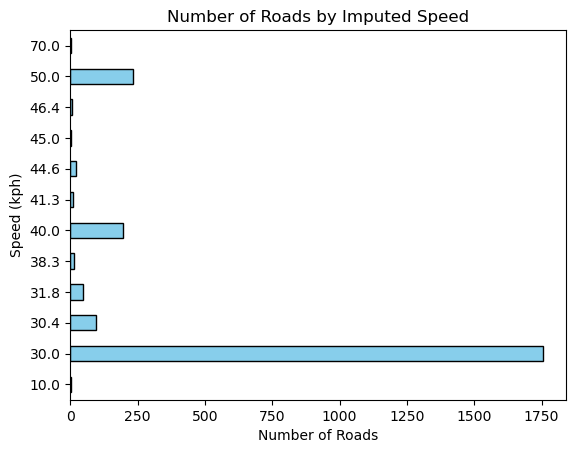

In [24]:
speed_counts = gruner_gdf_edges['speed_kph'].value_counts()
speed_counts = speed_counts.sort_index()
speed_counts.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Number of Roads by Imputed Speed')
plt.ylabel('Speed (kph)')
plt.xlabel('Number of Roads')
plt.show()

As we can see from the plot, the majority of the roads have an imputed road speed of 30 km/h, while the highest road speed is 70 km/h.

#### Comparing shortest VS fastest routes
Origin and Destination points were found at www.openstreetmap.org/ with right click> show address.

In [25]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(gruner_graph, X=10.75442, Y=59.92347)
dest = ox.distance.nearest_nodes(gruner_graph, X=10.79684, Y=59.93083)

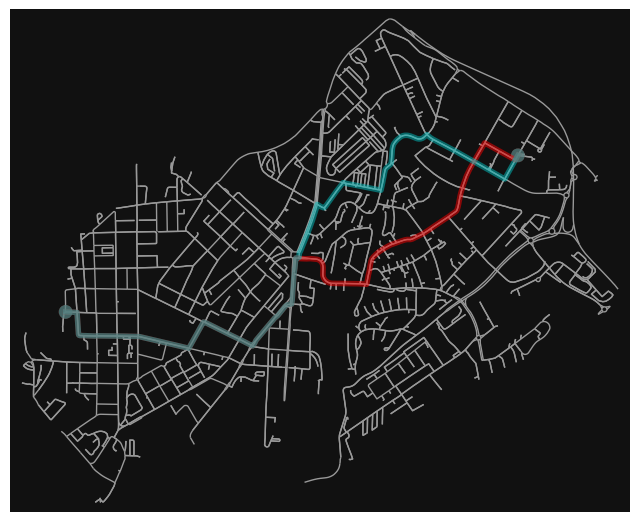

In [26]:
# find the shortest path between nodes
## one in terms of distance and another wrt. travel time
route_length = ox.shortest_path(gruner_graph, orig, dest, weight="length")
route_time = ox.shortest_path(gruner_graph, orig, dest, weight="travel_time")
# fig, ax = ox.plot_graph_route(gruner_graph, route_length, node_size=0)
fig, ax = ox.plot_graph_routes(gruner_graph, routes=[route_length, route_time], route_colors=["r", "c"], route_linewidth=6, node_size=0)

<div style="display: flex; align-items: center;">
    <div style="width: 24px; height: 12px; background-color: red; margin-right: 10px;"></div>
    <div>Route by Length</div>
</div>
<div style="display: flex; align-items: center;">
    <div style="width: 24px; height: 12px; background-color: cyan; margin-right: 10px;"></div>
    <div>Route by Travel Time</div>
</div>

The Cyan route minimizes travel time, and is thus longer but faster than the Red route.   
For more examples of travel time, see the isochrones example.   
For more examples of routing, including using elevation as an impedance, see the elevations example.

In [27]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.route_to_gdf(gruner_graph, route_length, "length")["length"]))
route2_length = int(sum(ox.utils_graph.route_to_gdf(gruner_graph, route_time, "length")["length"]))
route1_time = int(sum(ox.utils_graph.route_to_gdf(gruner_graph, route_length, "travel_time")["travel_time"]))
route2_time = int(sum(ox.utils_graph.route_to_gdf(gruner_graph, route_time, "travel_time")["travel_time"]))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 3463 meters and takes 369 seconds.
Route 2 is 3542 meters and takes 346 seconds.
